In [1]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from multiprocessing import Pool

import utils.lifesense_utils as ls_utils

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

%matplotlib inline

# Sentiment Analysis

## Load data

In [25]:
liwc = pd.read_csv("lexica/LIWC2015.csv")
liwc_categories = liwc['category'].unique()

In [26]:
liwc_categories

array(['PPRON', 'BODY', 'WE', 'DEATH', 'FOCUSFUTURE', 'FEEL', 'INTERROG',
       'NUMBER', 'POSEMO', 'NEGATE', 'QUANT', 'THEY', 'AFFECT', 'RELATIV',
       'HOME', 'CONJ', 'COGPROC', 'SEXUAL', 'AUXVERB', 'SHEHE', 'BIO',
       'DIFFER', 'POWER', 'NETSPEAK', 'INFORMAL', 'CAUSE', 'FILLER',
       'INSIGHT', 'LEISURE', 'NEGEMO', 'MOTION', 'SEE', 'FOCUSPAST',
       'ANGER', 'ARTICLE', 'NONFLU', 'MALE', 'WORK', 'FRIEND', 'FUNCTION',
       'RISK', 'FAMILY', 'SPACE', 'I', 'IPRON', 'SOCIAL', 'ASSENT',
       'DRIVES', 'PERCEPT', 'VERB', 'HEAR', 'FEMALE', 'DISCREP', 'YOU',
       'ADJ', 'ACHIEVE', 'RELIG', 'TENTAT', 'COMPARE', 'ADVERB',
       'PRONOUN', 'MONEY', 'FOCUSPRESENT', 'INGEST', 'AFFILIATION',
       'SWEAR', 'HEALTH', 'SAD', 'TIME', 'REWARD', 'ANX', 'PREP',
       'CERTAIN'], dtype=object)


# Sandbox

In [27]:
# raw data load
test_id = "20841577"

path = "/data/tliu/wave2_aggregate/2020-03-19/pdk-text-messages/{}.df"

test_msg_df = pd.read_pickle(path.format(test_id))
test_msg_df = ls_utils.format_time(test_msg_df)

In [28]:
test_msg_df['annotations'][0][0]['LIWC2015']

{'PPRON': 3,
 'TENTAT': 1,
 'FOCUSFUTURE': 1,
 'RELATIV': 1,
 'AFFECT': 1,
 'CONJ': 1,
 'YOU': 2,
 'INSIGHT': 1,
 'COGPROC': 2,
 'ARTICLE': 1,
 'FUNCTION': 6,
 'SPACE': 1,
 'I': 1,
 'DRIVES': 2,
 'VERB': 4,
 'AUXVERB': 2,
 'ACHIEVE': 1,
 'PRONOUN': 3,
 'POSEMO': 1,
 'FOCUSPRESENT': 3,
 'SOCIAL': 2,
 'REWARD': 1,
 'PREP': 1}

In [40]:
sel_df['direction'].value_counts()['incoming']

12

In [68]:
test_msg_df.groupby('direction')['length'].sum()

direction
incoming    50961
outgoing    36283
Name: length, dtype: int64

In [104]:
pids = []
wave2_id_file_loc = "/home/tliu/lifesense/wave2_wk4_ids.txt"
with open(wave2_id_file_loc, "r") as wave_f:
    for line in wave_f.readlines():
        pids.append(line.strip())

In [105]:
path = "/data/tliu/wave2_aggregate/2020-03-19/pdk-text-messages/{}.df"

test_msg_df = pd.read_pickle(path.format(test_id))

In [106]:
'outgoing' in test_msg_df['direction'].unique()

True

## Build LIWC DataFrame

In [131]:
%%time
# build daily incoming/outgoing LIWC counts
df_dict = {'pid': [],
           'date': [],
           'direction': [],
           'msg_count': [],
           'tot_msg_length': []}

for k in liwc_categories:
    df_dict[k] = []

#pids = [test_id]

for pid in pids:
    print(pid)
    
    msg_df = pd.read_pickle(path.format(pid))
    if msg_df.shape[0] == 0:
        continue
    msg_df = ls_utils.format_time(msg_df)

    
    for date in pd.Series(msg_df['date'].unique()):
        date = date.strftime("%Y-%m-%d")
        sel_df = msg_df[msg_df['date'] == date]

        in_dict = {k: 0 for k in liwc_categories}
        out_dict = {k: 0 for k in liwc_categories}

        for i, row in sel_df.iterrows():
            if row['direction'] == 'incoming':
                if 'LIWC2015' in row['annotations'][0]:
                    liwc_dict = row['annotations'][0]['LIWC2015']
                    for k, v in liwc_dict.items():
                        in_dict[k] += v

            elif row['direction'] == 'outgoing':
                if 'LIWC2015' in row['annotations'][0]:
                    liwc_dict = row['annotations'][0]['LIWC2015']
                    for k, v in liwc_dict.items():
                        out_dict[k] += v
            else:
                continue
                
        #incoming
        if 'incoming' in sel_df['direction'].unique():
            df_dict['pid'].append(pid)
            df_dict['date'].append(date)
            df_dict['direction'].append('incoming')
            df_dict['msg_count'].append(sel_df['direction'].value_counts()['incoming'])
            df_dict['tot_msg_length'].append(sel_df.groupby('direction')['length'].sum()['incoming'])
            for k,v in in_dict.items():
                df_dict[k].append(v)
        else:
            print("no incomings")
            df_dict['pid'].append(pid)
            df_dict['date'].append(date)
            df_dict['direction'].append('incoming')
            df_dict['msg_count'].append(0)
            df_dict['tot_msg_length'].append(0)
            for k,v in in_dict.items():
                df_dict[k].append(v)
        #outgoing
        if 'outgoing' in sel_df['direction'].unique():
            df_dict['pid'].append(pid)
            df_dict['date'].append(date)
            df_dict['direction'].append('outgoing')
            df_dict['msg_count'].append(sel_df['direction'].value_counts()['outgoing'])
            df_dict['tot_msg_length'].append(sel_df.groupby('direction')['length'].sum()['outgoing'])
            for k,v in out_dict.items():
                df_dict[k].append(v)
        else:
            print("no outgoings ")
            df_dict['pid'].append(pid)
            df_dict['date'].append(date)
            df_dict['direction'].append('outgoing')
            df_dict['msg_count'].append(0)
            df_dict['tot_msg_length'].append(0)
            for k,v in out_dict.items():
                df_dict[k].append(v)

14673820
no outgoings 
no outgoings 
no outgoings 
98724064
no outgoings 
no outgoings 
no outgoings 
no outgoings 
56462129
no incomings
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
92656094
no incomings
68460425
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
20841577
14456223
41532020
no outgoings 
no outgoings 
no incomings
23255906
79755032
03925638
70226916
no outgoings 
no outgoings 
no incomings
no outgoings 
no incomings
no incomings
no incomings
no incomings
no outgoings 
15266887
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
26222720
no outgoings 
no outgoings 
no outgoings 
no outgoings 
05498364
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
94758398
no outgoings 
no outgoings 
no outgoings 
no outgoin

no outgoings 
73062896
no outgoings 
99527269
no incomings
no incomings
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no incomings
28218945
no outgoings 
no outgoings 
no outgoings 
73771763
56227303
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
62043543
no outgoings 
no outgoings 
no outgoings 
no incomings
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
82450932
no outgoings 
no outgoings 
no outgoings 
no outgoings 
47537499
51034018
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
no outgoings 
29486061
no outgoings 
no o

In [132]:
liwc_df = pd.DataFrame.from_dict(df_dict)

In [133]:
liwc_df.groupby('direction')['msg_count'].sum()

direction
incoming    122996
outgoing     97818
Name: msg_count, dtype: int64

In [134]:
liwc_df.groupby('direction')['tot_msg_length'].sum()

direction
incoming    7384974
outgoing    4236896
Name: tot_msg_length, dtype: int64

In [140]:
liwc_df[liwc_df['msg_count'] == 0][liwc_categories].sum(axis=1)

,pid,date,direction,msg_count,tot_msg_length,PPRON,BODY,WE,DEATH,FOCUSFUTURE,...,INGEST,AFFILIATION,SWEAR,HEALTH,SAD,TIME,REWARD,ANX,PREP,CERTAIN
5,14673820,2020-02-03,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,14673820,2020-02-13,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,14673820,2020-02-16,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,98724064,2020-03-04,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161,98724064,2020-03-05,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,98724064,2020-03-06,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,98724064,2020-03-09,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
202,56462129,2020-02-08,incoming,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211,56462129,2020-02-12,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
213,56462129,2020-02-13,outgoing,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
test_id = '14673820'
test_df = pd.read_pickle(path.format(test_id))


In [160]:
test_df = ls_utils.format_time(test_df)


for i, row in test_df[(test_df['date'] == '2020-02-03')].iterrows():
    print(row['annotations'][0]['LIWC2015'])

{'PPRON': 1, 'TENTAT': 1, 'QUANT': 1, 'RELATIV': 2, 'AFFECT': 2, 'CONJ': 1, 'DIFFER': 1, 'POWER': 1, 'MOTION': 1, 'COGPROC': 1, 'ARTICLE': 2, 'FUNCTION': 7, 'SPACE': 1, 'DRIVES': 1, 'VERB': 1, 'DISCREP': 1, 'YOU': 1, 'ADJ': 3, 'ACHIEVE': 1, 'COMPARE': 1, 'PRONOUN': 1, 'POSEMO': 2, 'SOCIAL': 2, 'REWARD': 1, 'PREP': 3}
{'PPRON': 1, 'TENTAT': 1, 'QUANT': 1, 'RELATIV': 2, 'AFFECT': 2, 'CONJ': 1, 'DIFFER': 1, 'POWER': 1, 'MOTION': 1, 'COGPROC': 1, 'ARTICLE': 2, 'FUNCTION': 7, 'SPACE': 1, 'DRIVES': 1, 'VERB': 1, 'DISCREP': 1, 'YOU': 1, 'ADJ': 3, 'ACHIEVE': 1, 'COMPARE': 1, 'PRONOUN': 1, 'POSEMO': 2, 'SOCIAL': 2, 'REWARD': 1, 'PREP': 3}
{'PPRON': 1, 'TENTAT': 1, 'QUANT': 1, 'RELATIV': 2, 'AFFECT': 2, 'CONJ': 1, 'DIFFER': 1, 'POWER': 1, 'MOTION': 1, 'COGPROC': 1, 'ARTICLE': 2, 'FUNCTION': 7, 'SPACE': 1, 'DRIVES': 1, 'VERB': 1, 'DISCREP': 1, 'YOU': 1, 'ADJ': 3, 'ACHIEVE': 1, 'COMPARE': 1, 'PRONOUN': 1, 'POSEMO': 2, 'SOCIAL': 2, 'REWARD': 1, 'PREP': 3}
{'FUNCTION': 6, 'DIFFER': 1, 'PREP': 1, 'PR

In [162]:
liwc_df[(liwc_df['pid'] == test_id) & (liwc_df['date'] == '2020-02-03')]['SOCIAL']

4    7
5    0
Name: SOCIAL, dtype: int64

In [144]:
liwc_df['date'].unique().shape

(49,)

In [150]:
liwc_df['direction'].value_counts()

incoming    5370
outgoing    5370
Name: direction, dtype: int64

In [149]:
liwc_df.to_csv("lexica/wave2_liwc_2020_03_20.csv", index=False)

## Other Lexica

In [153]:
lexicas =[]

for pid in pids:
    print(pid)
    
    msg_df = pd.read_pickle(path.format(pid))
    if msg_df.shape[0] == 0:
        continue
    msg_df = ls_utils.format_time(msg_df)
    
    for i, row in msg_df.iterrows():
        lexicas.extend([x for x in row['annotations'][0].keys() if x not in lexicas])
                    

14673820
98724064
56462129
92656094
68460425
20841577
14456223
41532020
23255906
79755032
03925638
70226916
15266887
26222720
05498364
94758398
99558567
38070362
96968904
22425521
24390140
21517496
13195321
84995481
29504072
37057080
69045373
43521459
16052899
01515998
05348360
55300032
26192608
88666137
96819556
86209099
69820876
31651056
37329817
68526739
78980081
43080203
84821824
56525162
07919808
22584726
83857691
75406227
16241706
84966718
60827000
46177605
94193380
98287414
04229942
27318176
28749524
38300374
37998680
59984371
18273257
51287973
71526997
68154736
90730909
13229365
27410219
95932094
58535318
24458423
04045315
39742047
60975479
26603492
67141200
32454300
16899237
59655460
22775534
73062896
99527269
28218945
73771763
56227303
62043543
82450932
47537499
51034018
29486061
28506000
64117655
73715015
60640743
88503521
10834985
24778662
57478615
75306774
75628425
58517740
07981456
61398362
48639153
21279610
53832570
02334954
34031533
37841008
35277842
62731236
61157154
6

In [154]:
lexicas

['pronouns', 'stress', 'LIWC2015', 'NRC_Emolex_Hash', 'depression']

# Demographics Processing

## Relevant screening information

- age
- zip code
- PHQ8
- diagnosed depression/bipolar/ptsd/schizo/eating/substance
- gender
- race
- education
- fam_income
- personal_income
- health insurance
- working status
- panic disorder
- GAD7
- medication/treatment history
- BADS: behavioral assessment of dysexecutive syndrome
- UCLA loneliness
- SHAPS
- PSQI
- SPIN
- AUDIT
- DAST
- EDS: Everyday Discrimination Scale

In [168]:
path = "/home/tliu/lifesense/wave2_data/LS_Wave2_REDCap_scbl_wk1_4_032120.xlsx"

demo_df = pd.read_excel(path, sheet_name=0, dtype={'zipcode': str})
mapping_df = pd.read_excel(path, sheet_name=2, dtype={'case_number': str, 'app_id': str})

In [169]:
demo_df.head()

,record_id,redcap_event_name,dt_screen,dt_screen_start,us_res,us_citizen,age,zipcode,smartphone,smartphone_os,...,dast10_10,eds_start,eds_q1,eds_q2,eds_q3,eds_q4,eds_q5,txhx_start_fu,psytxhx_psychother_3wk,psytxhx_curr_meds_fu
0,2,scbl_arm_1,2020-01-14,2020-01-14 12:55:21,1.0,1.0,32.0,27707.0,1.0,2.0,...,0.0,2020-01-14 19:07:46,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN
1,2,week_1_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,week_4_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 12:18:42,0.0,1.0
3,4,scbl_arm_1,2020-01-14,2020-01-14 13:13:56,1.0,1.0,30.0,21617.0,1.0,2.0,...,0.0,2020-01-15 17:31:45,4.0,5.0,6.0,4.0,4.0,NaN,NaN,NaN
4,4,week_1_arm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
mapping_df.dtypes

record_id          int64
case_number       object
app_id            object
withdraw          object
enrollment_grp    object
dtype: object

In [182]:
mapping_dict = dict(zip(mapping_df['record_id'], mapping_df['app_id']))

In [183]:
mapping_dict

{2: '96432418',
 4: '16691034',
 6: '53770133',
 9: '74942494',
 10: '55531669',
 11: '76602711',
 12: '08332403',
 18: '79697615',
 20: '23303049',
 21: '33271731',
 24: '63501047',
 25: '18040903',
 26: '80654059',
 27: '50427429',
 31: '14673820',
 33: '98724064',
 35: '56462129',
 39: '92656094',
 41: '68460425',
 45: '20841577',
 56: '01880196',
 57: '14456223',
 60: '41532020',
 69: '23255906',
 70: '79755032',
 71: '03925638',
 74: '32031018',
 76: '32822307',
 78: '70226916',
 83: '21620012',
 87: '15266887',
 88: '26222720',
 90: '05498364',
 91: '42640545',
 94: '20091545',
 95: '43688623',
 98: '57759459',
 102: '67701555',
 103: '94758398',
 106: '99558567',
 107: '38070362',
 109: '96968904',
 110: '11428588',
 114: '22425521',
 115: '24390140',
 116: '21517496',
 117: '13195321',
 118: '84995481',
 123: '29504072',
 124: '37057080',
 125: '69045373',
 126: '43521459',
 130: '16052899',
 140: '01515998',
 144: '05348360',
 147: '55300032',
 158: '26192608',
 164: '88666137

In [184]:
demo_df['app_id'] = demo_df['record_id'].map(mapping_dict)

In [213]:
wave2_demo = demo_df[demo_df['app_id'].isin(pids)]
wave2_demo = wave2_demo[wave2_demo['redcap_event_name'] == 'scbl_arm_1']

## Gender distribution

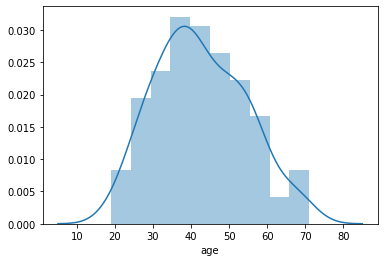

In [215]:
sns.distplot(wave2_demo['age'], bins=10)

In [216]:
display(wave2_demo['age'].describe())

count    138.000000
mean      42.471014
std       11.766085
min       19.000000
25%       34.000000
50%       41.000000
75%       51.000000
max       71.000000
Name: age, dtype: float64

In [217]:
wave2_demo['gender_id'].value_counts()

0.0    97
1.0    40
2.0     1
Name: gender_id, dtype: int64

In [218]:
wave2_demo['demo_race'].value_counts()

5.0     95
1.0     30
6.0      8
3.0      3
99.0     1
2.0      1
Name: demo_race, dtype: int64

### Race table

1, African American (Having origins in any of the black racial groups of Africa) | 2, American Indian (North, South or Central) or Alaska Native (Having origins in any of the original peoples of North, Central or South America) | 3, Asian (Having origins in any of the original peoples of the Far East, Southeast Asia, or the Indian Subcontinent. For example: Cambodia, China, India, Japan, Korea, Malaysia, Pakistan, the Philippine Islands, Thailand, and Vietnam) | 4, Native Hawaiian or Other Pacific Islander (Having origins in any of the original peoples of Hawaii, Guam, Samoa or other Pacific Islands) | 5, White (Having origins in any of the original peoples of Europe, the Middle East, or North Africa) | 6, More than one race | 77, Decline to report | 99, Prefer not to answer

## PHQ, GAD, SPIN

In [219]:
phq_cols = wave2_demo.columns[wave2_demo.columns.str.startswith('phq')]
phq_cols = phq_cols[:-1]
wave2_demo['tot_phq'] = wave2_demo[phq_cols].sum(axis=1)

In [229]:
wave2_demo['tot_phq'].describe()

count    138.000000
mean       9.905797
std        6.902753
min        0.000000
25%        4.000000
50%        8.000000
75%       15.750000
max       24.000000
Name: tot_phq, dtype: float64

In [227]:
gad_cols = wave2_demo.columns[wave2_demo.columns.str.startswith('gad')]
gad_cols = gad_cols[1:-1]
wave2_demo['tot_gad'] = wave2_demo[gad_cols].sum(axis=1)

In [228]:
wave2_demo['tot_gad'].describe()

count    138.000000
mean       8.594203
std        6.529705
min        0.000000
25%        3.000000
50%        7.000000
75%       14.000000
max       21.000000
Name: tot_gad, dtype: float64

In [233]:
spin_cols = wave2_demo.columns[wave2_demo.columns.str.startswith('spin')]
spin_cols = spin_cols[1:]
wave2_demo['tot_spin'] = wave2_demo[spin_cols].sum(axis=1)

In [234]:
wave2_demo['tot_spin'].describe()

count    138.000000
mean      25.818841
std       20.190782
min        0.000000
25%        9.000000
50%       20.000000
75%       44.750000
max       68.000000
Name: tot_spin, dtype: float64

In [235]:
wave2_demo['is_depressed'] = wave2_demo['tot_phq'] >= 10
wave2_demo['is_anxious'] = wave2_demo['tot_gad'] >= 10
wave2_demo['is_soc_anx'] = wave2_demo['tot_spin'] >= 20

In [237]:
wave2_demo['is_depressed'].value_counts()

False    79
True     59
Name: is_depressed, dtype: int64

In [238]:
wave2_demo['is_anxious'].value_counts()

False    80
True     58
Name: is_anxious, dtype: int64

In [239]:
wave2_demo['is_soc_anx'].value_counts()

True     71
False    67
Name: is_soc_anx, dtype: int64

# TODOs

- add functionality for splitting the graphs into two groups, based on the clinical cutoffs for each of these inventories
    - GAD >= 10
    - SPIN >= 20
    - PHQ >= 10